In [2]:
import gudhi as gd
from gudhi import representations
import numpy as np
import numpy.random
import matplotlib.pyplot as plt
import pingouin as pg
import scipy.stats as st
from collections import defaultdict

In [3]:
def get_pi(data):
    pi0s = []
    for dat in data:
        ac = gd.AlphaComplex(points = dat.reshape(-1,1))
        st = ac.create_simplex_tree()
        st.compute_persistence()
        pi0s.append(st.persistence_intervals_in_dimension(0))
    return pi0s

In [4]:
def train_statistics(RV, N, n_samples, n_samples_test, q=0.95):
    samples = [RV.rvs(N) for i in range(n_samples)]
    #if standarize_data:
    samples_std = [standarize(sample) for sample in samples]
    samples = samples_std.copy()
    
    pi0s = get_pi(samples)
    W1D = gd.representations.WassersteinDistance(n_jobs=-1, order=wasserstein_order, internal_p=wasserstein_p)
    W1_train = W1D.fit_transform(pi0s)

    samples_test = [RV.rvs(N) for i in range(n_samples_test)]
    #if standarize_data:
    samples_test_std = [standarize(sample) for sample in samples_test]
    samples_test = samples_test_std.copy()
    
    pi0s_test = get_pi(samples_test)
    W1_test = W1D.transform(pi0s_test)

    dmean = np.mean(W1_test, axis=1)
    dmin = np.min(W1_test, axis=1)
    dmax = np.max(W1_test, axis=1)
    dq = np.quantile(W1_test, q=0.9, axis=1)
    qmean = np.quantile(dmean, q)
    qmin = np.quantile(dmin, q)
    qmax = np.quantile(dmax, q)
    qq = np.quantile(dq, q)
    return W1D, qmin, qmean, qmax, qq, dmin, dmean, dmax, dq

In [5]:
def standarize(X):
    return (X-np.mean(X))/np.std(X)

def topo_test(samples, W1D, qmin, qmean, qmax, qq):
    #if standarize_data:
    samples_std = [standarize(sample) for sample in samples]
    samples = samples_std.copy()
    
    pi0s = get_pi(samples)
    W1_test = W1D.transform(pi0s)
    dmin = np.min(W1_test, axis=1)
    dmax = np.max(W1_test, axis=1)
    dmean = np.mean(W1_test, axis=1)
    dq = np.quantile(W1_test, q=0.9, axis=1) # takie samo q jak w train_statistcs
    
    is_normal_min = dmin < qmin
    is_normal_mean = dmean < qmean
    is_normal_max = dmax < qmax
    is_normal_q = dq < qq
    
    p_empirical_min = np.sum(is_normal_min)/len(is_normal_min)
    p_empirical_mean = np.sum(is_normal_mean)/len(is_normal_mean)
    p_empirical_max = np.sum(is_normal_max)/len(is_normal_max)
    p_empirical_q = np.sum(is_normal_q)/len(is_normal_q)
    return p_empirical_min, p_empirical_mean, p_empirical_max, p_empirical_q

def normality_tests(samples):
    def anderson(sample):
        anderson_out = st.anderson(sample, 'norm')
        return anderson_out.statistic < anderson_out.critical_values[2]

    shapiro = [st.shapiro(sample).pvalue >0.05 for sample in samples]
    ks = [st.kstest(sample, 'norm').pvalue >0.05 for sample in samples]
    cvm = [st.cramervonmises(sample, 'norm').pvalue >0.05 for sample in samples]
    ad = [anderson(sample) for sample in samples]
    
    shapiro = np.sum(shapiro)/len(shapiro)
    ks = np.sum(ks)/len(ks)
    ad = np.sum(ad)/len(ad)
    cvm = np.sum(cvm)/len(cvm)
    return shapiro, ks, ad, cvm

In [6]:
# generate other distributions to measure test power
# first check normal distribution
def empirical_test_power(RV, W1D, qmin, qmean, qmax, qq, N=100, n_samples=250):
    samples_topo = [RV.rvs(N) for i in range(n_samples)]
    mu = RV.stats('m')
    std = np.sqrt(RV.stats('v'))
    samples = [(sample-mu)/std for sample in samples_topo]
    topo_min, topo_mean, topo_max, topo_q = topo_test(samples_topo, W1D, qmin, qmean, qmax, qq)
    power_shapiro, power_ks, power_ad, power_cvm = normality_tests(samples)
    return topo_min, topo_mean, topo_max, topo_q, power_shapiro, power_ks, power_ad, power_cvm

In [7]:
# https://www.semanticscholar.org/paper/Power-comparisons-of-Shapiro-Wilk-%2C-%2C-Lilliefors-Razali-Wah/dcdc0a0be7d65257c4e6a9117f69e246fb227423

rv_normal = st.norm()
rv_normal2_2 = st.norm(2,2)
rv_beta2_2 = st.beta(2, 2)
rv_beta5_5 = st.beta(5, 5)
rv_beta10_10 = st.beta(10, 10)
rv_laplace = st.laplace()
rv_uniform = st.uniform()
rv_t3 = st.t(df=3)
rv_t5 = st.t(df=5)
rv_t7 = st.t(df=7)
rv_t10 = st.t(df=10)
rv_gamma10_1 = st.gamma(10,1)
rv_gamma20_1 = st.gamma(20,1)
rv_gamma4_5 = st.gamma(4,5)
rv_chisq4 = st.chi2(df=4)
rv_chisq10 = st.chi2(df=10)
rv_lorentz = st.cauchy()

wasserstein_p = 1
wasserstein_order = 1
standarize_data = True

outputfilename = f'results/{wasserstein_p}_{wasserstein_order}_{standarize_data}_distrib_std'

rvs = [rv_normal, rv_normal2_2, rv_beta2_2, rv_beta5_5, rv_beta10_10, rv_laplace, rv_uniform, rv_t3, rv_t5, rv_t7, rv_t10, 
       rv_gamma10_1, rv_gamma20_1, rv_gamma4_5, rv_chisq4, rv_chisq10, rv_lorentz]
rv_names = ['Normal01', 'Normal22', 'Beta22', 'Beta55', 'Beta1010', 'Laplace', 'Uniform', 't3', 't5', 't7', 't10', 
            'G10_1', 'G20_1', 'G4_5', 'ChiSq4', 'ChiSq10', 'Lorentz']    

In [9]:
n_samples = 500
mc_loops = 750
results = defaultdict(list)
resuts_stats = {}

for N in [10, 20, 30, 50, 100, 150, 200, 250, 300, 400, 500]:
    # compute the  distance matrix for normal distribution for given data size N
    W1D, qmin, qmean, qmax, qq, dmin, dmean, dmax, dq = train_statistics(rv_normal, N=N, n_samples=n_samples, n_samples_test=750, q=0.95)
    resuts_stats[N] = [W1D, qmin, qmean, qmax, qq, dmin, dmean, dmax, dq]
    
    for rv, rv_name in zip(rvs, rv_names):
        print(f'N={N} rv_name={rv_name}')
        results[rv_name].append([N, *empirical_test_power(RV=rv, W1D=W1D, qmin=qmin, qmean=qmean, qmax=qmax, qq=qq, N=N, n_samples=mc_loops)])
    
    np.save(outputfilename+'.npy', results)
    np.save(outputfilename+'_stats.npy', resuts_stats)

N=10 rv_name=Normal01
N=10 rv_name=Normal22
N=10 rv_name=Beta22
N=10 rv_name=Beta55
N=10 rv_name=Beta1010
N=10 rv_name=Laplace
N=10 rv_name=Uniform
N=10 rv_name=t3
N=10 rv_name=t5
N=10 rv_name=t7
N=10 rv_name=t10
N=10 rv_name=G10_1
N=10 rv_name=G20_1
N=10 rv_name=G4_5
N=10 rv_name=ChiSq4
N=10 rv_name=ChiSq10
N=10 rv_name=Lorentz
N=20 rv_name=Normal01
N=20 rv_name=Normal22
N=20 rv_name=Beta22
N=20 rv_name=Beta55
N=20 rv_name=Beta1010
N=20 rv_name=Laplace
N=20 rv_name=Uniform
N=20 rv_name=t3
N=20 rv_name=t5
N=20 rv_name=t7
N=20 rv_name=t10
N=20 rv_name=G10_1
N=20 rv_name=G20_1
N=20 rv_name=G4_5
N=20 rv_name=ChiSq4
N=20 rv_name=ChiSq10
N=20 rv_name=Lorentz
N=30 rv_name=Normal01
N=30 rv_name=Normal22
N=30 rv_name=Beta22
N=30 rv_name=Beta55
N=30 rv_name=Beta1010
N=30 rv_name=Laplace
N=30 rv_name=Uniform
N=30 rv_name=t3
N=30 rv_name=t5
N=30 rv_name=t7
N=30 rv_name=t10
N=30 rv_name=G10_1
N=30 rv_name=G20_1
N=30 rv_name=G4_5
N=30 rv_name=ChiSq4
N=30 rv_name=ChiSq10
N=30 rv_name=Lorentz
N=50 rv

KeyboardInterrupt: 

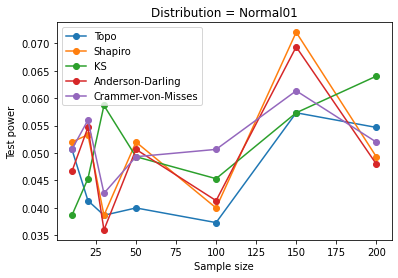

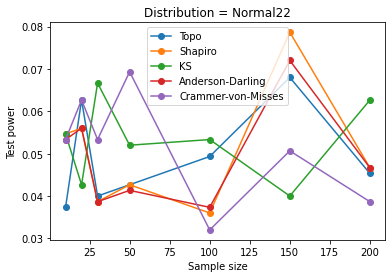

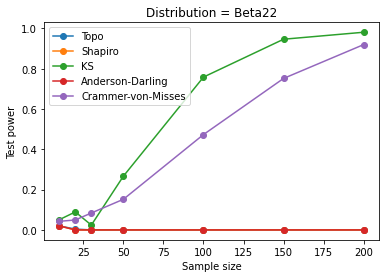

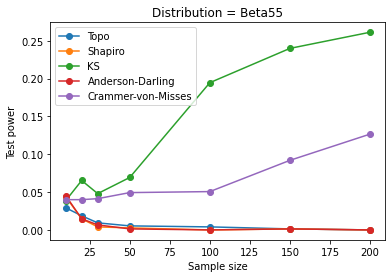

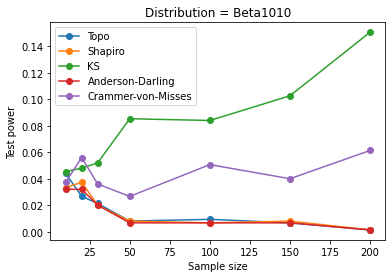

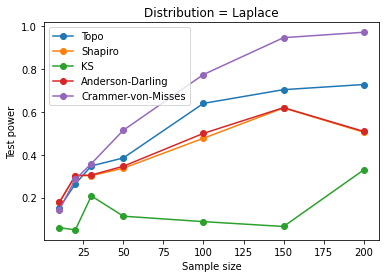

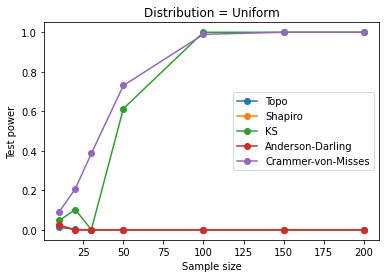

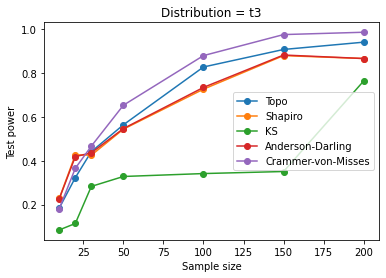

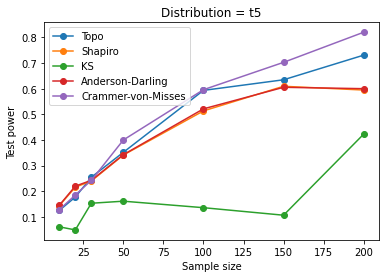

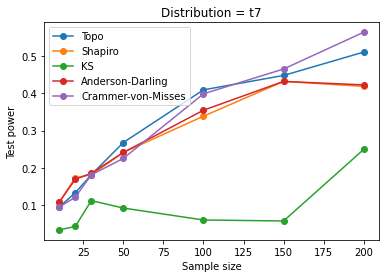

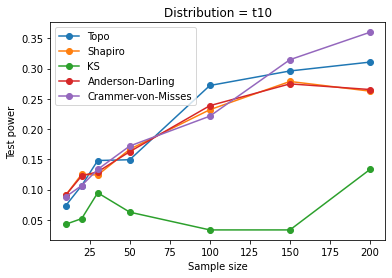

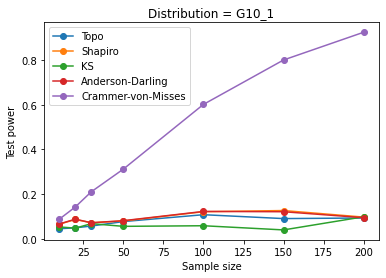

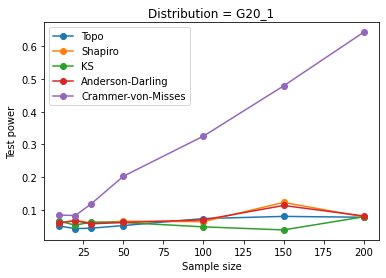

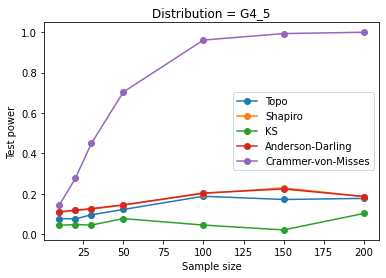

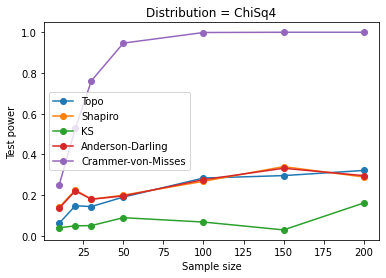

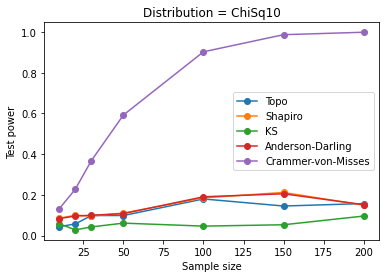

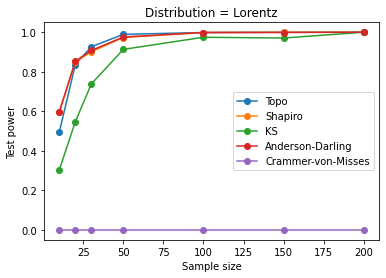

In [11]:
for dist_name in results.keys():
    data = results[dist_name]
    data = np.array(data)
    plt.plot(data[:, 0], 1-data[:, 1], 'o-', label='Topo')
    plt.plot(data[:, 0], 1-data[:, 2], 'o-', label='Shapiro')
    plt.plot(data[:, 0], 1-data[:, 3], 'o-', label='KS')
    plt.plot(data[:, 0], 1-data[:, 4], 'o-', label='Anderson-Darling')
    plt.plot(data[:, 0], 1-data[:, 5], 'o-', label='Crammer-von-Misses')
    plt.xlabel('Sample size')
    plt.ylabel('Test power')
    plt.title(f'Distribution = {dist_name}')
    plt.legend()
    plt.savefig(outputfilename+'_'+dist_name+'.png')
    plt.show()